# Minimal Combined Experiment

This notebook demonstrates how to run the combined experiment that collects both Likert evaluation results and hidden states in a single pass.


In [1]:
# Setup imports
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Add the project root to the path to allow imports
repo_root = Path.cwd()
if not (repo_root / "abstainer").exists():
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

# Suppress tqdm warnings about ipywidgets
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")


In [2]:
# Import required functions
from abstainer.src.experiment import load_combined_results, run_combined_experiment
from abstainer.src.experiment_utils import get_questions_by_filter
from abstainer.src.model import load_model


## 1. Configure the experiment parameters

Set up your experiment parameters below. You can customize:
- Model ID
- Question filters (subject, difficulty, split)
- Prompt form (V0-V5 for different description styles)
- Custom labels for the Likert options


In [3]:
# Model configuration
model_id = "google/gemma-3-4b-it"  # Replace with your model

# Output directory
output_dir = Path("./results/minimal_experiment")
output_dir.mkdir(parents=True, exist_ok=True)

# Question filters (set to None to include all)
subject = "Physics"     # Filter by subject: "Physics", "Biology", etc.
difficulty = None       # Filter by difficulty: "1", "2", "3", etc.
split = "dev"           # Filter by split: "train", "dev", "test"

# Prompt configuration
form = "V2"             # Choose description style: "V0", "V1", "V2", "V3", "V4", "V5"
                        # V0: "Definitely yes/no"
                        # V1: "Yes/No, I'm sure"
                        # V2: "Certainly yes/no"
                        # V3: "Yes/No, absolutely"
                        # V4: "Strongly yes/no"
                        # V5: "Yes/No, without doubt"

# Custom labels (set to None to use default A-E)
labels = ["A", "B", "C", "D", "E"]  # Labels in order: definitely_yes, probably_yes, not_sure, probably_no, definitely_no
# Alternative examples:
# labels = ["1", "2", "3", "4", "5"]
# labels = ["YES", "LIKELY", "UNSURE", "UNLIKELY", "NO"]

# Experiment control
force_reprocess = True  # Set to False to use existing results if available


## 2. Load model and get questions


In [4]:
# Load model
print(f"Loading model: {model_id}")
tokenizer, model = load_model(model_id)

# Get questions based on filters
questions = get_questions_by_filter(
    subject=subject,
    difficulty=difficulty,
    split=split
)

print(f"Found {len(questions)} questions matching filters")

# Display a few example questions
if questions:
    for i, q in enumerate(questions[:3]):
        print(f"\nQuestion {i+1}: {q['question']}")
        print(f"ID: {q['id']}, Subject: {q['subject']}, Difficulty: {q['difficulty']}")
else:
    print("No questions found matching the filters. Try different filter criteria.")


Loading model: google/gemma-3-4b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Found 10 questions matching filters

Question 1: Is friction a force that opposes motion?
ID: Q-000103, Subject: Physics, Difficulty: 1

Question 2: Does sound travel faster in a vacuum than in air?
ID: Q-000106, Subject: Physics, Difficulty: 1

Question 3: Is Ohm's law related to electrical circuits?
ID: Q-000112, Subject: Physics, Difficulty: 2


## 3. Run the combined experiment


In [5]:
# Run the combined experiment
print(f"Running combined experiment with form '{form}'...")
if labels:
    print(f"Using custom labels: {labels}")

results = run_combined_experiment(
    model=model,
    tokenizer=tokenizer,
    output_dir=str(output_dir),
    questions=questions,
    form=form,
    labels=labels,
    verbose=True,
    force_reprocess=force_reprocess
)

# Print summary statistics
print("\nExperiment completed!")
print(f"Likert evaluation: {results['likert_stats']['completed_questions']} questions processed")
if 'average_score' in results['likert_stats']:
    print(f"Average score: {results['likert_stats']['average_score']:.2f}")
print(f"Score distribution: {results['likert_stats']['score_distribution']}")
print(f"Hidden states: {results['hidden_stats']['completed_questions']} questions processed")
print(f"Hidden state shape: {results['hidden_stats']['hidden_state_shape']}")

# Output file paths
print("\nOutput files:")
for name, path in results["output_files"].items():
    print(f"- {name}: {path}")


Running combined experiment with form 'V2'...
Using custom labels: ['A', 'B', 'C', 'D', 'E']
Processing 10 questions with Likert form 'V2'


100%|██████████| 10/10 [01:04<00:00,  6.45s/it]


Saved Likert results for 10 questions to results/minimal_experiment/likert_results_V2.json
Saved hidden states for 10 questions to results/minimal_experiment/hidden_states_V2.npz
Saved metadata to results/minimal_experiment/hidden_states_V2.json

Experiment completed!
Likert evaluation: 10 questions processed
Average score: 0.80
Score distribution: {'-3': 0, '-2': 2, '-1': 0, '0': 1, '1': 2, '2': 5}
Hidden states: 10 questions processed
Hidden state shape: (35, 2560)

Output files:
- likert: results/minimal_experiment/likert_results_V2.json
- hidden_states: results/minimal_experiment/hidden_states_V2.npz
- metadata: results/minimal_experiment/hidden_states_V2.json


## 4. Load and analyze results


In [6]:
# Load the results
data = load_combined_results(str(output_dir), form=form)

print(f"Loaded {len(data['likert_results'])} Likert results")
print(f"Loaded {len(data['hidden_states'])} hidden state tensors")

# Example: Look at the first question
if data['likert_results']:
    first_qid = next(iter(data['likert_results']))
    result = data['likert_results'][first_qid]
    hidden_state = data['hidden_states'].get(first_qid)

    print(f"\nExample question (ID: {first_qid}):")
    print(f"Question: {result['question']}")
    print(f"Answer: {result['answer']}")
    print(f"Predicted label: {result['pred_label']}")
    print(f"Canonical label: {result['canonical_label']}")
    print(f"Score: {result['score']}")

    if hidden_state is not None:
        print(f"Hidden state shape: {hidden_state.shape}")

        # Example: Show normalized probabilities for this question
        print("\nProbabilities:")
        for label, prob in result['probs_norm'].items():
            print(f"  {label}: {prob:.4f}")

        print("\nCanonical probabilities:")
        for label, prob in result['canonical_probs_norm'].items():
            print(f"  {label}: {prob:.4f}")


Loaded 10 Likert results
Loaded 10 hidden state tensors

Example question (ID: Q-000103):
Question: Is friction a force that opposes motion?
Answer: Yes
Predicted label: A
Canonical label: YY
Score: 2
Hidden state shape: (35, 2560)

Probabilities:
  A: 0.9999
  B: 0.0001
  C: 0.0000
  D: 0.0000
  E: 0.0000

Canonical probabilities:
  YY: 0.9999
  Y: 0.0001
  A: 0.0000
  N: 0.0000
  NN: 0.0000


## 5. Visualize hidden states


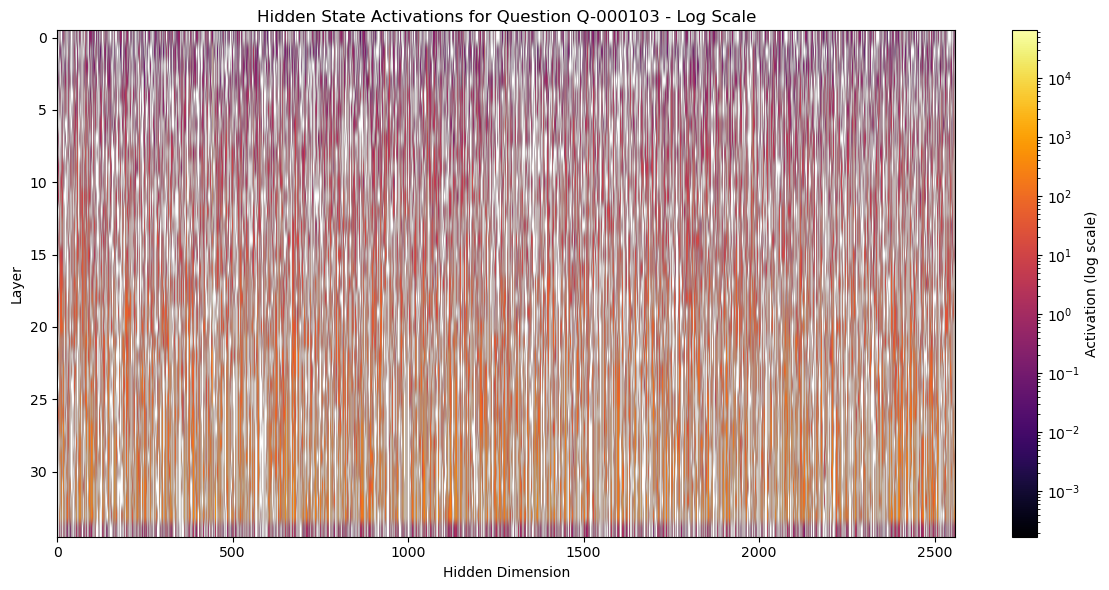

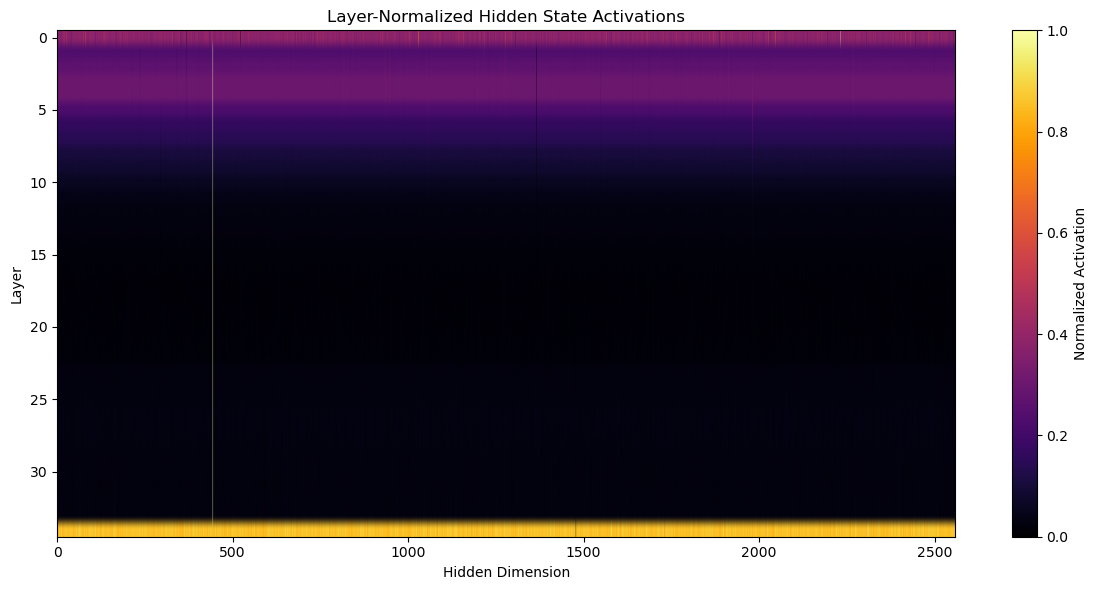

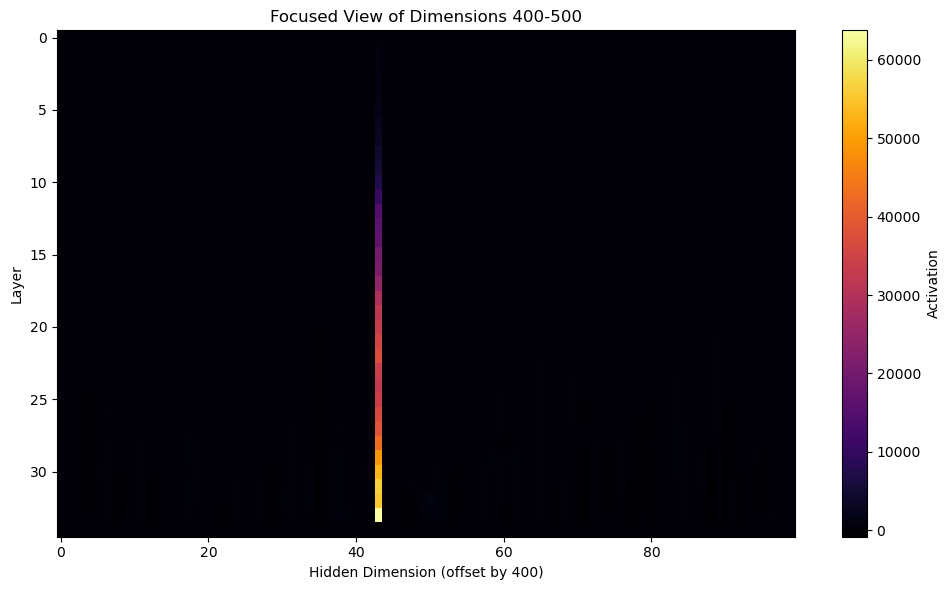

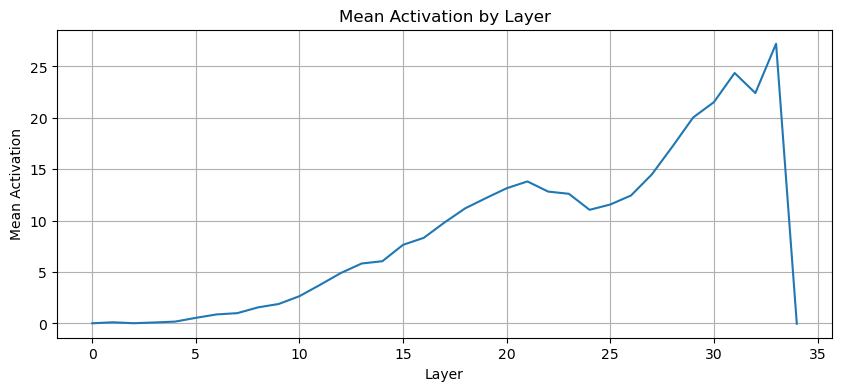

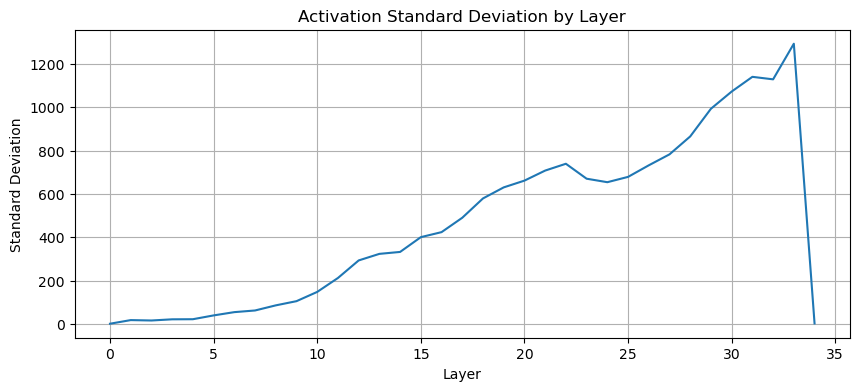

In [14]:
# Visualize hidden states for a question
if data['hidden_states'] and first_qid in data['hidden_states']:
    hidden_state = data['hidden_states'][first_qid]

    # 1. Use a logarithmic normalization to better visualize the range of values
    plt.figure(figsize=(12, 6))
    plt.imshow(hidden_state, aspect='auto', cmap='inferno', norm=plt.matplotlib.colors.LogNorm())
    plt.colorbar(label='Activation (log scale)')
    plt.title(f"Hidden State Activations for Question {first_qid} - Log Scale")
    plt.xlabel("Hidden Dimension")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    # 2. Normalize each layer to highlight relative activations within layers
    normalized_state = np.zeros_like(hidden_state)
    for i in range(hidden_state.shape[0]):
        layer = hidden_state[i]
        layer_min, layer_max = layer.min(), layer.max()
        if layer_max > layer_min:  # Avoid division by zero
            normalized_state[i] = (layer - layer_min) / (layer_max - layer_min)

    plt.figure(figsize=(12, 6))
    plt.imshow(normalized_state, aspect='auto', cmap='inferno')
    plt.colorbar(label='Normalized Activation')
    plt.title("Layer-Normalized Hidden State Activations")
    plt.xlabel("Hidden Dimension")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    # 3. Focus on the interesting region around dimension 450
    interesting_region = hidden_state[:, 400:500]
    plt.figure(figsize=(10, 6))
    plt.imshow(interesting_region, aspect='auto', cmap='inferno')
    plt.colorbar(label='Activation')
    plt.title("Focused View of Dimensions 400-500")
    plt.xlabel("Hidden Dimension (offset by 400)")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    # 4. Plot the average activation per layer
    plt.figure(figsize=(10, 4))
    layer_means = hidden_state.mean(axis=1)
    plt.plot(layer_means)
    plt.title("Mean Activation by Layer")
    plt.xlabel("Layer")
    plt.ylabel("Mean Activation")
    plt.grid(True)
    plt.show()

    # 5. Plot the standard deviation of activations per layer
    plt.figure(figsize=(10, 4))
    layer_stds = hidden_state.std(axis=1)
    plt.plot(layer_stds)
    plt.title("Activation Standard Deviation by Layer")
    plt.xlabel("Layer")
    plt.ylabel("Standard Deviation")
    plt.grid(True)
    plt.show()


## 6. Compare correct vs. incorrect predictions


Number of correct predictions: 7
Number of incorrect predictions: 2


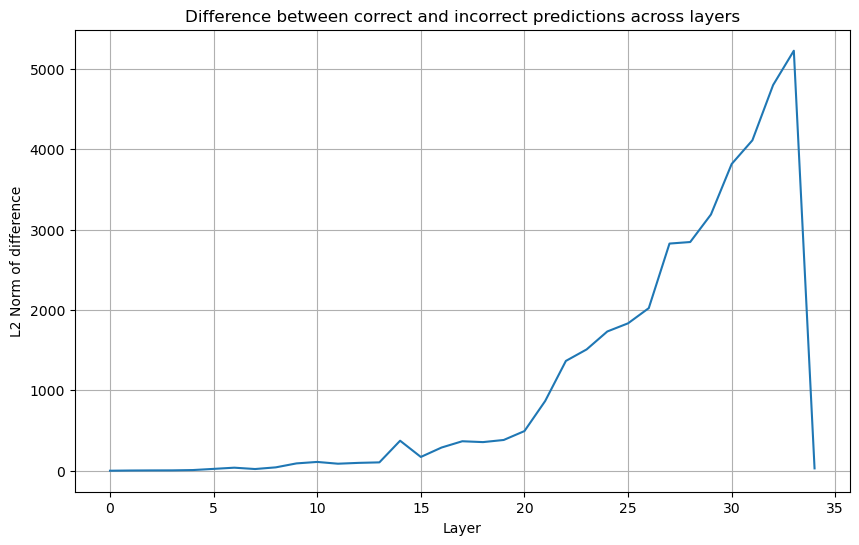

In [9]:
# Compare hidden states for correct vs. incorrect predictions
correct_ids = [qid for qid, result in data['likert_results'].items() if result['score'] > 0]
incorrect_ids = [qid for qid, result in data['likert_results'].items() if result['score'] < 0]

print(f"Number of correct predictions: {len(correct_ids)}")
print(f"Number of incorrect predictions: {len(incorrect_ids)}")

# Function to compute average hidden state across a set of question IDs
def compute_avg_hidden_state(question_ids):
    if not question_ids:
        return None

    # Get hidden states for the specified questions
    hidden_states = [data['hidden_states'][qid] for qid in question_ids if qid in data['hidden_states']]

    if not hidden_states:
        return None

    # Stack and average
    return np.mean(np.stack(hidden_states), axis=0)

# Only proceed if we have both correct and incorrect examples
if correct_ids and incorrect_ids:
    # Compute average hidden states
    avg_correct = compute_avg_hidden_state(correct_ids)
    avg_incorrect = compute_avg_hidden_state(incorrect_ids)

    if avg_correct is not None and avg_incorrect is not None:
        # Compute difference between correct and incorrect
        diff = avg_correct - avg_incorrect

        # Plot the norm of the difference across layers
        layer_norms = np.linalg.norm(diff, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(layer_norms)
        plt.title("Difference between correct and incorrect predictions across layers")
        plt.xlabel("Layer")
        plt.ylabel("L2 Norm of difference")
        plt.grid(True)
        plt.show()
